#install

In [0]:
!pip install chainer
!pip install cupy-cuda92

In [0]:
!pip install chainercv

#import

In [0]:
from google.colab import files
import matplotlib.pyplot as plt
import copy
import chainer
import xml.etree.ElementTree as ET
from chainercv.chainer_experimental.datasets.sliceable import GetterDataset
import os
from chainercv.utils import read_image

from chainer.datasets import ConcatenatedDataset
from chainer.datasets import TransformDataset
from chainer.optimizer_hooks import WeightDecay
from chainer import serializers
from chainer import training
from chainer.training import extensions
from chainer.training import triggers
from chainer.iterators import serial_iterator

import chainermn

from chainercv import utils
from chainercv import transforms
from chainercv.visualizations import vis_bbox
from chainercv.chainer_experimental.datasets.sliceable import ConcatenatedDataset
from chainercv.chainer_experimental.datasets.sliceable import TransformDataset
from chainercv.datasets import voc_bbox_label_names
from chainercv.datasets import VOCBboxDataset
from chainercv.extensions import DetectionVOCEvaluator
from chainercv.links.model.ssd import GradientScaling
from chainercv.links.model.ssd import multibox_loss
from chainercv.links.model.ssd import random_crop_with_bbox_constraints
from chainercv.links.model.ssd import resize_with_random_interpolation
from chainercv.links.model.ssd import random_distort
from chainercv.links import SSD300
from chainercv.links import SSD512

#ChainerCVの動作確認

In [0]:
model = SSD300(
    n_fg_class=len(voc_bbox_label_names),
    pretrained_model='voc0712'
)
model.score_thresh = 0.50
model.nms_thresh = 0.45
img = utils.read_image('a11_R.jpg', color=True)
bboxes, labels, scores = model.predict([img])
bbox, label, score = bboxes[0], labels[0], scores[0]

vis_bbox(
    img, bbox, label, score, label_names=voc_bbox_label_names)
plt.show()


#Fine-tuning

In [0]:
def get_shape_mismatch_names(src, dst):
    # all parameters are assumed to be initialized
    mismatch_names = []
    src_params = {p[0]: p[1] for p in src.namedparams()}
    for dst_named_param in dst.namedparams():
        name = dst_named_param[0]
        dst_param = dst_named_param[1]
        src_param = src_params[name]
        if src_param.shape != dst_param.shape:
            mismatch_names.append(name)
    return mismatch_names

In [0]:
from chainercv.links import SSD300
import numpy as np

src = SSD300(pretrained_model='voc0712')
# the number of classes in VOC is different from 50
dst = SSD300(n_fg_class=21)
# initialized weights
dst(np.zeros((1, 3, dst.insize, dst.insize), dtype=np.float32))

# the method described above
ignore_names = get_shape_mismatch_names(src, dst)
src_params = {p[0]: p[1] for p in src.namedparams()}
for dst_named_param in dst.namedparams():
    name = dst_named_param[0]
    if name not in ignore_names:
        dst_named_param[1].array[:] = src_params[name].array[:]

# check that weights are transfered
np.testing.assert_equal(dst.extractor.conv1_1.W.data,
                        src.extractor.conv1_1.W.data)
# the names of the weights that are skipped
print(ignore_names)

#Learning

In [0]:
class MultiboxTrainChain(chainer.Chain):

    def __init__(self, model, alpha=1, k=3):
        super(MultiboxTrainChain, self).__init__()
        with self.init_scope():
            self.model = model
        self.alpha = alpha
        self.k = k

    def __call__(self, imgs, gt_mb_locs, gt_mb_labels):
        mb_locs, mb_confs = self.model(imgs)
        loc_loss, conf_loss = multibox_loss(
            mb_locs, mb_confs, gt_mb_locs, gt_mb_labels, self.k)
        loss = loc_loss * self.alpha + conf_loss

        chainer.reporter.report(
            {'loss': loss, 'loss/loc': loc_loss, 'loss/conf': conf_loss},
            self)

        return loss

In [0]:
class Transform(object):

    def __init__(self, coder, size, mean):
        # to send cpu, make a copy
        self.coder = copy.copy(coder)
        self.coder.to_cpu()

        self.size = size
        self.mean = mean

    def __call__(self, in_data):
        # There are five data augmentation steps
        # 1. Color augmentation
        # 2. Random expansion
        # 3. Random cropping
        # 4. Resizing with random interpolation
        # 5. Random horizontal flipping

        img, bbox, label = in_data

        # 1. Color augmentation
        img = random_distort(img)

        # 2. Random expansion
        if np.random.randint(2):
            img, param = transforms.random_expand(
                img, fill=self.mean, return_param=True)
            bbox = transforms.translate_bbox(
                bbox, y_offset=param['y_offset'], x_offset=param['x_offset'])
        

        # 3. Random cropping
        img, param = random_crop_with_bbox_constraints(
            img, bbox, return_param=True)
        bbox, param = transforms.crop_bbox(
            bbox, y_slice=param['y_slice'], x_slice=param['x_slice'],
            allow_outside_center=False, return_param=True)
        #print(bbox)
        #print('param', param)
        #print('label', label)
        label = label[param['index']]
        # 4. Resizing with random interpolatation
        _, H, W = img.shape
        img = resize_with_random_interpolation(img, (self.size, self.size))
        bbox = transforms.resize_bbox(bbox, (H, W), (self.size, self.size))

        # 5. Random horizontal flipping
        img, params = transforms.random_flip(
            img, x_random=True, return_param=True)
        bbox = transforms.flip_bbox(
            bbox, (self.size, self.size), x_flip=params['x_flip'])

        # Preparation for SSD network
        img -= self.mean
        mb_loc, mb_label = self.coder.encode(bbox, label)

        return img, mb_loc, mb_label

In [0]:
class originalDataset(GetterDataset):
  def __init__(self,split='train',use_difficult=False,return_difficult=False):
    super(originalDataset, self).__init__()
    
    data_dir = 'detaset/'+split+'/'
    
    ids = []
    for files in os.listdir(data_dir+'image'):
      ids.append(files[:-4])
    
    self.ids = ids
    self.data_dir = data_dir
    self.use_difficult = use_difficult

    self.add_getter('img', self._get_image)
    self.add_getter(('bbox', 'label', 'difficult'), self._get_annotations)

    if not return_difficult:
      self.keys = ('img', 'bbox', 'label')
            
            
  def __len__(self):
    
    return len(self.ids)
  def _get_image(self,i):
    _id = self.ids[i]
    img = read_image(self.data_dir+'image/'+_id+'.png')
    return img
  def _get_annotations(self,i):
    bbox = []
    label = []
    difficult = []
    _id = self.ids[i]
    anno = ET.parse(os.path.join(self.data_dir+'xml/'+_id+'.xml'))
    for obj in anno.findall('object'):
      bndbox_anno = obj.find('bndbox')
      bbox.append([
          int(bndbox_anno.find(tag).text) - 1
          for tag in ('ymin', 'xmin', 'ymax', 'xmax')])
    label.append(20)
    difficult.append(False)
    bbox = np.array(bbox,dtype=np.float32)
    label = np.array(label,dtype=np.int32)
    difficult = np.array(difficult,dtype=np.bool)
    return bbox, label, difficult

#run

In [0]:
gpu = 0
batchsize = 32
test_batchsize = 16
iteration = 120
step = [80, 100]
out = 'result'
resume = None #たぶん重み

model = dst

model.use_preset('evaluate')
train_chain = MultiboxTrainChain(model)

chainer.cuda.get_device_from_id(gpu).use()
model.to_gpu()

train = TransformDataset(
    originalDataset(split='train'),
    ('img', 'mb_loc', 'mb_label'),
    Transform(model.coder, model.insize, model.mean))
train_iter = chainer.iterators.MultiprocessIterator(train, batchsize)

test = originalDataset(
    split='test', use_difficult=True, return_difficult=True)
test_iter = chainer.iterators.SerialIterator(
    test, batchsize, repeat=False, shuffle=False)

# initial lr is set to 1e-3 by ExponentialShift
optimizer = chainer.optimizers.MomentumSGD()
optimizer.setup(train_chain)
for param in train_chain.params():
  if param.name == 'b':
    param.update_rule.add_hook(GradientScaling(2))
  else:
    param.update_rule.add_hook(WeightDecay(0.0005))

updater = training.updaters.StandardUpdater(
    train_iter, optimizer, device=gpu)
trainer = training.Trainer(
    updater, (iteration, 'iteration'), out)
trainer.extend(
    extensions.ExponentialShift('lr', 0.1, init=1e-3),
    trigger=triggers.ManualScheduleTrigger(step, 'iteration'))

trainer.extend(
    DetectionVOCEvaluator(
        test_iter, model, use_07_metric=True,
        label_names=(voc_bbox_label_names+('new_label',))))

log_interval = 10, 'iteration'
trainer.extend(extensions.LogReport(trigger=log_interval))
trainer.extend(extensions.observe_lr(), trigger=log_interval)
trainer.extend(extensions.PrintReport(
    ['epoch', 'iteration', 'lr',
     'main/loss', 'main/loss/loc', 'main/loss/conf',
     'validation/main/map']),
               trigger=log_interval)
trainer.extend(extensions.ProgressBar(update_interval=10))

trainer.extend(
    extensions.snapshot(),
    trigger=triggers.ManualScheduleTrigger(
        step + [iteration], 'iteration'))
trainer.extend(
    extensions.snapshot_object(model, 'model_iter_{.updater.iteration}'),
    trigger=(iteration, 'iteration'))

if resume:
  serializers.load_npz(resume, trainer)

trainer.run()


#認識

In [0]:
#image upload
uploaded = files.upload()

Saving 16_51_05_892480.png to 16_51_05_892480.png


In [0]:
!unzip detaset.zip

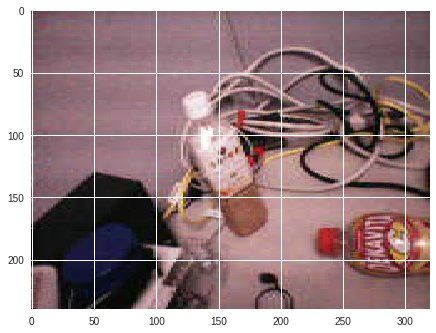

In [0]:
model.score_thresh = 0.50
model.nms_thresh = 0.45
img = utils.read_image('16_51_05_892480.png', color=True)
bboxes, labels, scores = model.predict([img])
bbox, label, score = bboxes[0], labels[0], scores[0]

vis_bbox(
    img, bbox, label, score, label_names=voc_bbox_label_names+('target',))
plt.show()
